# Introduction

Currently, the MLB uses human umpires to determine ball/strike calls at home plate for each pitch in a baseball game. While it has been the standard since the sport's inception, there are some that believe an update is needed to the game that automates this process, primarily for the purpose of accuracy. A machine with sensors (photogrammetry, videography, radar, lidar) can much better detect the exact location of a baseball as it crosses home plate than the human eye can, regardless of hours of training a person to perform this action.

Independent of whether this notion of "upgrading the game" is correct or not, it poses an interesting machine learning problem: Can a model accurately create the strikezone for each player that comes to the plate?

The answer is "yes", but how would it be performed? This script will take information from the MLB statcast for each pitch in a particular time period, and for each particular player up to bat. From there it will attempt to categorize balls and strikes based on each player.

The biggest limitation to the data for this model will undoubtedly be the "ball/strike" as called by the umpire. Since we have no other way (at the moment) to create a better strike zone from scratch, we can only use the one established by each umpire. This comes with human error, since sometimes the umpires get it wrong (hence the desire for this model in the first place). An assumption will be made in the beginning that these erreneous calls can be considered "outliers" and will not affect the models ability to generalize. However, if it becomes too much of a factor, we will need to perform some data cleaning in order to remedy the situation.

## Imports

Packages that will be necessary for this analysis. They will be installed in our virtaul environment first via `pip`, then imported. Luckily for us, somebody has already made a python scraper for the data we are looking for. We can utilize that here to make obtaining the data a bit easier.

In [36]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

#import matplotlib so that we can use dark background for seaborn
from matplotlib import pyplot as plt
plt.style.use('dark_background')
import tensorflow as tf

#MLB Scraper grabs from MLB statcast and savant
from pybaseball import statcast

## Data Extraction

Lets grab some pitch data from the statcast just to see what we are working with

In [8]:
# Nothing special about these dates
start = '2022-05-01'
finish = '2022-05-02'

df = statcast(start_dt=start, end_dt=finish)
df.head()

This is a large query, it may take a moment to complete


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1569,FS,2022-05-02,97.6,-1.97,6.29,"Duran, Jhoan",663527,661395,strikeout,swinging_strike,...,2,2,1,1,2,Standard,Standard,221,-0.044,-0.06
1598,CU,2022-05-02,87.9,-1.98,6.3,"Duran, Jhoan",663527,661395,NaN,foul,...,2,2,1,1,2,Standard,Standard,57,0.0,0.0
1645,FS,2022-05-02,97.3,-2.15,6.3,"Duran, Jhoan",663527,661395,NaN,called_strike,...,2,2,1,1,2,Standard,Standard,218,0.0,-0.022
1748,FS,2022-05-02,96.9,-2.27,6.16,"Duran, Jhoan",663527,661395,NaN,swinging_strike,...,2,2,1,1,2,Standard,Standard,223,0.0,-0.018
1821,FS,2022-05-02,97.8,-2.17,6.27,"Duran, Jhoan",663624,661395,field_out,hit_into_play,...,2,2,1,1,2,Standard,Standard,225,-0.064,-0.16


Alright, so it looks like we have 92 unique features in this dataset. While we can look at pitch metrics momentarily, the first issue I see is the columns "batter" and "pitcher". It looks like they are associated with numbers, and I am unsure who those numbers are meant to represent. The documentation on mlb savant, or the python package, may be able to help us track down that information.

Because I still have the github open, it looks like the number for batter and pitcher is defined as "MLBAM ID". Not entirely sure what that is at the moment, but one piece of information we can immediately discern is that "player_name" feature refers to the pitcher, just by looking at the first 5 datapoints. Notice that the batter number changes after 3 strikes called (count strikes in the "description" column). However, the pitcher number does not, so that's some useful info. Still, we need some `key:value` pairs to associate batter # with who they actually are.

Doing some digging, a website `smartfantasybaseball.com` contains a list of mlb player id's to their names. Luckily, it comes with a .csv file, so we can add that to our dataframe to better understand the players up to bat. However, this is not required initially, because our model does not necessarily need to know their names. It simply helps us understand the person we are modeling. Therefore, we will save this step for last.

# Data Cleaning

So, after looking at the columns in the dataframe and the rows in the dataframe, it is already becoming clear that the order that the rows got entered into the dataframe is a bit odd. The index of the data does not match the index of the dataframe. However, this is not really a problem, because I intend to organize the data by batter ID for now (and eventually change this to batter name).

In [14]:
data = df.set_index(['batter'])
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
batter,,,,,,,,,,,,,,,,,,,,,
663527,FS,2022-05-02,97.6,-1.97,6.29,"Duran, Jhoan",661395,strikeout,swinging_strike,<NA>,...,2,2,1,1,2,Standard,Standard,221,-0.044,-0.06
663527,CU,2022-05-02,87.9,-1.98,6.3,"Duran, Jhoan",661395,NaN,foul,<NA>,...,2,2,1,1,2,Standard,Standard,57,0.0,0.0
663527,FS,2022-05-02,97.3,-2.15,6.3,"Duran, Jhoan",661395,NaN,called_strike,<NA>,...,2,2,1,1,2,Standard,Standard,218,0.0,-0.022
663527,FS,2022-05-02,96.9,-2.27,6.16,"Duran, Jhoan",661395,NaN,swinging_strike,<NA>,...,2,2,1,1,2,Standard,Standard,223,0.0,-0.018
663624,FS,2022-05-02,97.8,-2.17,6.27,"Duran, Jhoan",661395,field_out,hit_into_play,<NA>,...,2,2,1,1,2,Standard,Standard,225,-0.064,-0.16


In [13]:
data
data.iloc[0]

pitch_type                                FS
game_date                2022-05-02 00:00:00
release_speed                           97.6
release_pos_x                          -1.97
release_pos_z                           6.29
                                ...         
if_fielding_alignment               Standard
of_fielding_alignment               Standard
spin_axis                                221
delta_home_win_exp                    -0.044
delta_run_exp                          -0.06
Name: 663527, Length: 91, dtype: object

Great, so it looks like our reindexing is successful, and aligns how we would expect with `pandas.iloc[]`. 

## Ball/Strikes Only

For this model, we are only interested in snippets of the data where there was a called strike or ball by the umpire. We will certainly explore more of this data in the future, but this will be first. We also want to get rid of any events where the batter swung at a pitch, since this could have unintended consequences for the data (what if the player swung at a ball? We would classify it as a strike, but it could be well outside the strike zone).

Lets take a look at what categories are offered by the `description` column of the dataframe

In [15]:
data['description'].unique()

array(['swinging_strike', 'foul', 'called_strike', 'hit_into_play',
       'ball', 'blocked_ball', 'foul_tip', 'foul_bunt',
       'swinging_strike_blocked', 'hit_by_pitch'], dtype=object)

Perfect, so it looks like we want to filter down our data by `called_strike`, 'blocked_ball', and `ball` (blocked ball being a ball that the catcher stopped from going into the backstop). This should give us the data we would want to feed into the model.

In [18]:
filter = data[(data['description'] == 'called_strike') |
               (data['description'] == 'blocked_ball') |
               (data['description'] == 'ball')]

filter.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
batter,,,,,,,,,,,,,,,,,,,,,
663527,FS,2022-05-02,97.3,-2.15,6.3,"Duran, Jhoan",661395,NaN,called_strike,<NA>,...,2,2,1,1,2,Standard,Standard,218,0.0,-0.022
623993,CU,2022-05-02,88.2,-2.0,6.41,"Duran, Jhoan",661395,NaN,ball,<NA>,...,2,2,1,1,2,Infield shift,Standard,45,0.0,0.017
623993,FF,2022-05-02,99.5,-2.13,6.42,"Duran, Jhoan",661395,NaN,called_strike,<NA>,...,2,2,1,1,2,Strategic,Strategic,222,0.0,-0.034
669304,SL,2022-05-02,83.1,2.51,5.19,"Fry, Paul",643316,NaN,ball,<NA>,...,1,2,1,2,1,Standard,Standard,310,0.0,0.016
596146,FF,2022-05-02,91.0,2.45,5.2,"Fry, Paul",643316,NaN,ball,<NA>,...,1,2,1,2,1,Infield shift,Standard,135,0.0,0.032
596146,SL,2022-05-02,84.4,2.56,5.17,"Fry, Paul",643316,NaN,ball,<NA>,...,1,2,1,2,1,Strategic,Standard,299,0.0,0.023
593871,SL,2022-05-02,83.9,2.51,5.17,"Fry, Paul",643316,NaN,called_strike,<NA>,...,1,2,1,2,1,Standard,Standard,335,0.0,-0.055
593871,FF,2022-05-02,91.7,2.43,5.26,"Fry, Paul",643316,NaN,ball,<NA>,...,1,2,1,2,1,Standard,Standard,135,0.0,0.025
593871,SL,2022-05-02,83.0,2.47,5.23,"Fry, Paul",643316,NaN,called_strike,<NA>,...,1,2,1,2,1,Standard,Standard,308,0.0,-0.034


Success, we filtered down the data a bit. These ball / strike calls will be used for our labels going into Tensorflow (after we "one-hot" them). Now, we need to get our desired features in order.

Suppose we are already planning on performing the model on each batter, such that the strike zone will be unique to each batter (and we can even eventually get a 'global' strikezone). If this is the case, what features do we use to determine the zone? The obvious answer is distance from certain x,y coordinates from the plate. 

Looking at the documentation from baseball savant, it looks like we can use the following:
1. `plate_x`: Horizontal position of the ball when it crosses home plate from the catcher's perspective.
2. `plate_z`: Vertical position of the ball when it crosses home plate from the catcher's perspective.

Pretty much exactly what we are looking for. Now we can determine a relationship between each ball/strike call, and the position of the ball when it crosses the plate. Lets make some plots for all batters and see what comes up!


/home/mattgpaul/Documents/Python Projects/AutoStrikeZone/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


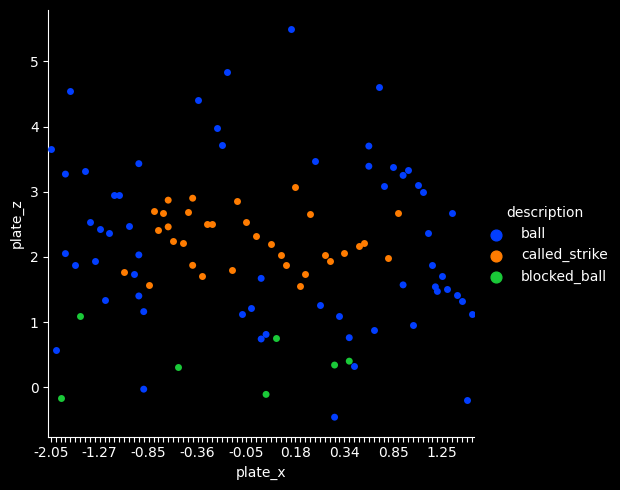

In [38]:
catplot = sns.catplot(x='plate_x', 
                      y='plate_z', 
                      hue='description', 
                      kind='swarm', 
                      data=filter.sample(100),
                      palette=sns.color_palette('bright'))
for index, label in enumerate(catplot.ax.get_xticklabels()):
    if index % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)


Well well well. Just looking at the plots and we can see some obvious categorical areas from the spread of the data. Furthermore, it is pretty obvious that we should also simply classify `blocked_ball` as a `ball` when we eventually remap the dataframe with a one-hot. We could also benefit from normalizing the features. Not strictly necessary here, but we will do it anyway.